# 测试

In [1]:
from datasets import load_dataset

dataset = load_dataset('snli')

Using the latest cached version of the module from /root/.cache/huggingface/modules/datasets_modules/datasets/snli/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b (last modified on Tue Oct  4 10:42:09 2022) since it couldn't be found locally at snli., or remotely on the Hugging Face Hub.
Reusing dataset snli (/root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
len(dataset['train']), len(dataset['test']), len(dataset['validation'])

(550152, 10000, 10000)

In [10]:
dataset['train'][0]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1}

In [13]:
for i, sen in enumerate(dataset['train']['premise']):
    if sen[-1] != '.' and not (97 <= ord(sen[-1]) <= 122):
        print(i, sen)
        break

282 A couple, who appear to be Indian or Pakistani, walk on a path beside a body of water, the mother carrying a child in a diaper, the father wrapped in a blanket with the logo of the humanitarian organization "Save the Children."


In [8]:
import re


def process(sentence):
    sentence = re.sub(r'[^0-9a-zA-Z]', ' ', sentence)
    sentence = re.sub('\\s{2,}', ' ', sentence)
    return sentence


premise = [process(sen) for sen in dataset['train']['premise']]
hypothesis = [process(sen) for sen in dataset['train']['hypothesis']]

In [9]:
from d2l import torch as d2l
all_premise_tokens = d2l.tokenize(premise)
all_hypothesis_tokens = d2l.tokenize(hypothesis)

In [11]:
print(f'最大语句长度: {max([len(a) + len(b) for a, b in zip(all_premise_tokens, all_hypothesis_tokens)])}')
# print(f'hypothesis的最大语句长度: {max([len(i) for i in all_hypothesis_tokens])}')

最大语句长度: 114


In [13]:
' '.join(all_premise_tokens[282])

'A couple who appear to be Indian or Pakistani walk on a path beside a body of water the mother carrying a child in a diaper the father wrapped in a blanket with the logo of the humanitarian organization Save the Children'

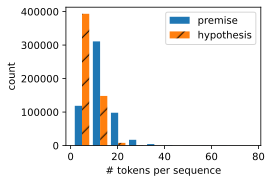

In [10]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['premise', 'hypothesis'], '# tokens per sequence',
                        'count', all_premise_tokens, all_hypothesis_tokens);

In [ ]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in all_hypothesis_tokens], bins=range(0, 100, 5));

In [14]:
vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens, min_freq=5, reserved_tokens=['<pad>'])
len(vocab)

18029

In [5]:
import multiprocessing
import os
import torch

In [6]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        premise = [process(sen) for sen in dataset['premise']]
        hypothesis = [process(sen) for sen in dataset['hypothesis']]
        # all_premise_hypothesis_tokens = [d2l.tokenize(sentences)
        #     for sentences in [premise, hypothesis]]
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize(sentences)
              for sentences in [premise, hypothesis]])]
        print(len(all_premise_hypothesis_tokens))

        self.labels = torch.tensor(dataset['label'])
        if vocab is None:
            self.vocab = d2l.Vocab(d2l.tokenize(premise + hypothesis), min_freq=5,
                                   reserved_tokens=['<pad>', '<cls>', '<pad>', '<sep>'])
        else:
            self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        # pool = multiprocessing.Pool(4)  # 使用4个进程
        # out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        out = list(map(self._mp_worker, all_premise_hypothesis_tokens))
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [7]:
batch_size, max_len, num_workers = 512, 128, 4

In [8]:
# 3.32 1min
train_set = SNLIBERTDataset(dataset['train'], max_len)

550152
read 550152 examples


In [16]:
for (token, segments, valid_len), label in train_set:
    print(' '.join([train_set.vocab.idx_to_token[x] for x in token]))
    print(f'词元: {token}\n分割: {segments}\n有效长度: {valid_len}\n 标签: {label}')
    break

<cls> A person on a horse jumps over a broken down airplane <sep> A person is training his horse for a competition <sep> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
词元: tensor([   2,    6,   47,   11,    5,  199,  211,   84,    5, 1169,   42,  828,
           4,    6,   47,    8, 1178,   23,  199,   40,    5,  462,    4,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
     

In [9]:
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)

In [10]:
len(train_iter)

1075

In [12]:
vocab = train_set.vocab
print(f"训练集词表大小: {len(vocab)}")

训练集词表大小: 18032


In [17]:
from torch import nn

In [20]:
# 常规编码器
class BaseEncoder(nn.Module):
    """采用BERT编码器结构"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=128, key_size=512, query_size=512, value_size=512,
                 **kwargs):
        super(BaseEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        self.agg_layer = nn.Sequential(nn.Linear(num_hiddens, num_hiddens),
                                      nn.ReLU())
        self.output = nn.Linear(num_hiddens, 3)
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        # 取句首'<cls>'标签对应的输出向量用于分类
        return self.output(self.agg_layer(X[:, 0, :]))

In [21]:
net = BaseEncoder(len(vocab), 512, [512], 512, 2048, 8, 2, 0.1)

In [26]:
for (token, segments, valid_len), label in train_iter:
    print(token.shape, segments.shape, valid_len.shape, label.shape)
    break

torch.Size([512, 128]) torch.Size([512, 128]) torch.Size([512]) torch.Size([512])


In [28]:
net(token, segments, valid_len).shape

torch.Size([512, 3])

In [29]:
class FamAttention(nn.Module):
    """修改多头注意力，针对嵌入512维，8个head的模型"""

    def __init__(self, num_hiddens, dim_dict, dropout, bias=False, **kwargs):
        super(FamAttention, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dim_dict = dim_dict
        self.dim_0 = [dim for dim, idx in self.dim_dict.items() if idx == 0]
        self.dim_1 = [dim for dim, idx in self.dim_dict.items() if idx == 1]
        self.dim_2 = [dim for dim, idx in self.dim_dict.items() if idx == 2]
        self.dim_3 = [dim for dim, idx in self.dim_dict.items() if idx == 3]
        self.dim_4 = [dim for dim, idx in self.dim_dict.items() if idx == 4]
        self.dim_5 = [dim for dim, idx in self.dim_dict.items() if idx == 5]
        self.dim_6 = [dim for dim, idx in self.dim_dict.items() if idx == 6]
        self.dim_7 = [dim for dim, idx in self.dim_dict.items() if idx == 7]
        # self.list_concat = torch.cat((self.dim_0, self.dim_1, self.dim_2, self.dim_3, self.dim_4, self.dim_5,
        # self.dim_6, self.dim_7))
        self.len_0, self.len_1, self.len_2, self.len_3, self.len_4, self.len_5, self.len_6, self.len_7 = len(
            self.dim_0), len(self.dim_1), len(self.dim_2), len(self.dim_3), len(self.dim_4), len(self.dim_5),\
            len(self.dim_6), len(self.dim_7)

        self.Wq0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wq1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wq2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wq3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wq4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wq5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wq6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wq7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wk0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wk1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wk2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wk3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wk4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wk5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wk6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wk7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wv0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wv1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wv2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wv3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wv4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wv5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wv6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wv7 = nn.Linear(self.len_7, self.len_7, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        def assemble(output_concat, list_concat):
            reslist = []
            for i in range(512):
                reslist.append(list_concat.index(i))
            return torch.index_select(output_concat, -1, torch.tensor(reslist, device=output_concat.device))

        # queries, keys, values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # qi, ki, vi的形状：(batch_size, 查询或者“键－值”对的个数， self.len_i)
        q0, k0, v0 = torch.index_select(queries, -1, torch.tensor(self.dim_0, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_0, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_0, device=values.device))
        q1, k1, v1 = torch.index_select(queries, -1, torch.tensor(self.dim_1, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_1, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_1, device=values.device))
        q2, k2, v2 = torch.index_select(queries, -1, torch.tensor(self.dim_2, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_2, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_2, device=values.device))
        q3, k3, v3 = torch.index_select(queries, -1, torch.tensor(self.dim_3, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_3, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_3, device=values.device))
        q4, k4, v4 = torch.index_select(queries, -1, torch.tensor(self.dim_4, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_4, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_4, device=values.device))
        q5, k5, v5 = torch.index_select(queries, -1, torch.tensor(self.dim_5, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_5, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_5, device=values.device))
        q6, k6, v6 = torch.index_select(queries, -1, torch.tensor(self.dim_6, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_6, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_6, device=values.device))
        q7, k7, v7 = torch.index_select(queries, -1, torch.tensor(self.dim_7, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_7, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_7, device=values.device))

        head0 = self.attention(self.Wq0(q0), self.Wk0(k0), self.Wv0(v0), valid_lens)
        head1 = self.attention(self.Wq1(q1), self.Wk1(k1), self.Wv1(v1), valid_lens)
        head2 = self.attention(self.Wq2(q2), self.Wk2(k2), self.Wv2(v2), valid_lens)
        head3 = self.attention(self.Wq3(q3), self.Wk3(k3), self.Wv3(v3), valid_lens)
        head4 = self.attention(self.Wq4(q4), self.Wk4(k4), self.Wv4(v4), valid_lens)
        head5 = self.attention(self.Wq5(q5), self.Wk5(k5), self.Wv5(v5), valid_lens)
        head6 = self.attention(self.Wq6(q6), self.Wk6(k6), self.Wv6(v6), valid_lens)
        head7 = self.attention(self.Wq7(q7), self.Wk7(k7), self.Wv7(v7), valid_lens)

        output_concat = torch.cat((head0, head1, head2, head3, head4, head5, head6, head7), dim=-1)
        list_concat = self.dim_0 + self.dim_1 + self.dim_2 + self.dim_3 + self.dim_4 + self.dim_5 + self.dim_6 + self.dim_7
        return self.W_o(assemble(output_concat, list_concat))

In [30]:
# 编码器块
class EncoderBlock(nn.Module):
    """transformer编码器块"""

    def __init__(self, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = FamAttention(num_hiddens, dim_dict, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [33]:
class FamEncoder(nn.Module):
    """采用BERT编码器结构"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout, max_len=128,
                 **kwargs):
        super(FamEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        self.agg_layer = nn.Sequential(nn.Linear(num_hiddens, num_hiddens),
                                      nn.ReLU())
        self.output = nn.Linear(num_hiddens, 3)
        for i in range(num_layers):
            self.blks.add_module(f"{i}", EncoderBlock(
                num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, dim_dict, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        # 取句首'<cls>'标签对应的输出向量用于分类
        return self.output(self.agg_layer(X[:, 0, :]))

In [34]:
dim_dict = dict()
for i in range(512):
    dim_dict[i] = i // 64

fnet = FamEncoder(len(vocab), 512, [512], 512, 2048, dim_dict, 2, 0.1)

In [35]:
fnet(token, segments, valid_len).shape

torch.Size([512, 3])

In [36]:
device = d2l.try_gpu()
fnet.to(device)
token, segments, valid_len = [v.to(device) for v in (token, segments, valid_len)]
fnet.eval()
fnet(token, segments, valid_len).shape

torch.Size([512, 3])

# 数据准备

In [1]:
import datasets
from datasets import load_dataset


dataset = load_dataset('snli')
# filter_dataset = dataset.filter(lambda x: x['train']['label'] != -1)
len(dataset['train']), len(dataset['test']), len(dataset['validation'])

Reusing dataset snli (/root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

(550152, 10000, 10000)

In [2]:
dataset = dataset.filter(lambda x: x['label'] != -1)

Loading cached processed dataset at /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-a456b5c8e4a9be8b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-23b15657e1b03e29.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-107582d3946c7465.arrow


In [3]:
print(len(dataset['train']), len(dataset['test']), len(dataset['validation']))
dataset['train'][0]

549367 9824 9842


{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1}

# 训练词向量

In [38]:
a = ['def', 'frgg', 'grgw2']
b = ['fqag', 'uiqg', 'odqg', 'oppf']
a + b

['def', 'frgg', 'grgw2', 'fqag', 'uiqg', 'odqg', 'oppf']

In [39]:
# 预处理训练数据集中的所有前提和假设文本，用于训练词向量
import re


def process(sentence):
    sentence = re.sub(r'[^0-9a-zA-Z]', ' ', sentence)
    sentence = re.sub('\\s{2,}', ' ', sentence)
    return sentence

premise = [process(sen) for sen in dataset['train']['premise']]
hypothesis = [process(sen) for sen in dataset['train']['hypothesis']]

all_word_tokens = d2l.tokenize(premise + hypothesis)
print(len(all_word_tokens))
all_word_tokens[600]

1100304


['A', 'little', 'boy', 'swims', 'underwater']

In [ ]:
U.S.  U S

In [40]:
from gensim.models import word2vec

file_path = 'autodl-tmp/'
model = word2vec.Word2Vec(sentences=all_word_tokens, vector_size=512, sg=1, min_count=5)

In [43]:
print(f'词向量模型中保存的单词数量为 {len(model.wv.index_to_key)}')
model.save(file_path + "snli_word_vec_sg.bin")

词向量模型中保存的单词数量为 18027


# 因子分析

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from gensim.models import word2vec
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

In [3]:
file_path = 'autodl-tmp/'

In [4]:
model = word2vec.Word2Vec.load(file_path + 'snli_word_vec_sg.bin')

In [5]:
embedding = np.array([model.wv[word] for word in model.wv.index_to_key])
embedding.shape

(18027, 512)

In [47]:
# 查看某个单词的词向量
model.wv.key_to_index['film']
model.wv['film']

2803

In [6]:
# Bartlett's球状检验
print('Bartlett\'s球状检验: 检验总体变量的相关矩阵是否是单位阵')
chi_square_value, p_value = calculate_bartlett_sphericity(embedding)
print(chi_square_value, p_value)

# 导入kmo检验
print('kmo检验:')
print('检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好')
kmo_all, kmo_model = calculate_kmo(embedding)
print('KMO值为: ', kmo_model)

Bartlett's球状检验: 检验总体变量的相关矩阵是否是单位阵
7768554.243774692 0.0
kmo检验:
检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO值为:  0.44138183310886825


In [49]:
# fa = FactorAnalyzer(25, rotation='varimax')
print('******因子分析******')
fa = FactorAnalyzer(25, rotation='varimax')
fa.fit(embedding)

# 特征值、特征向量
ev, v = fa.get_eigenvalues()

******因子分析******


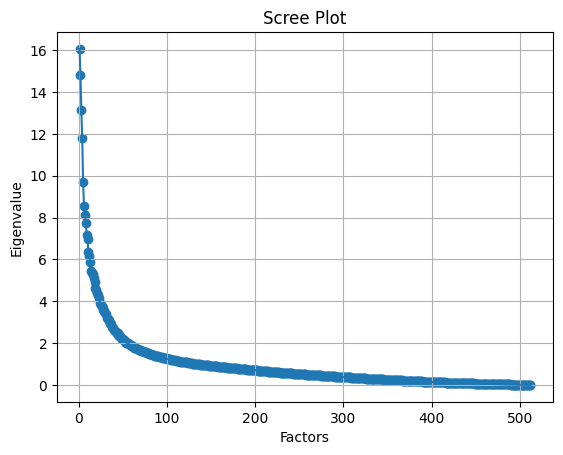

In [50]:
# 可视化, plot横轴是指标个数，纵轴是ev值
plt.scatter(range(1, embedding.shape[1]+1), ev)
plt.plot(range(1, embedding.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# plt.savefig('ev.png')

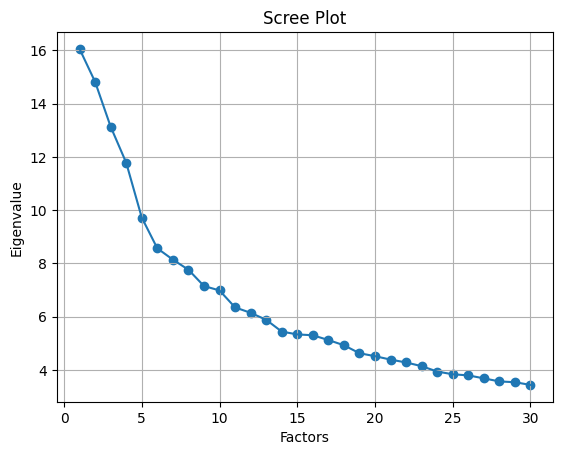

In [51]:
# 前三十
plt.scatter(range(1, 31), ev[:30])
plt.plot(range(1, 31), ev[:30])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
# plt.savefig(file_path + 'ev30.png')

In [9]:
# fa = FactorAnalyzer(8, rotation="promax")
# fa.fit(embedding)
# print(fa.loadings_.shape)

# 512*8(变量个数*因子个数)
index = fa.loadings_.argmax(axis=1)
res = np.array([[i, idx] for i, idx in enumerate(index)])

data_1 = pd.DataFrame(fa.loadings_, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])
data_2 = pd.DataFrame(res, columns=['Dimension', 'Factor'])
with pd.ExcelWriter(file_path + "snliFA.xls") as writer1:
    data_1.to_excel(writer1, sheet_name="Sheet1")
    data_2.to_excel(writer1, sheet_name="Sheet2")
    writer1.save()

Text(120.72222222222221, 0.5, 'Dimension')

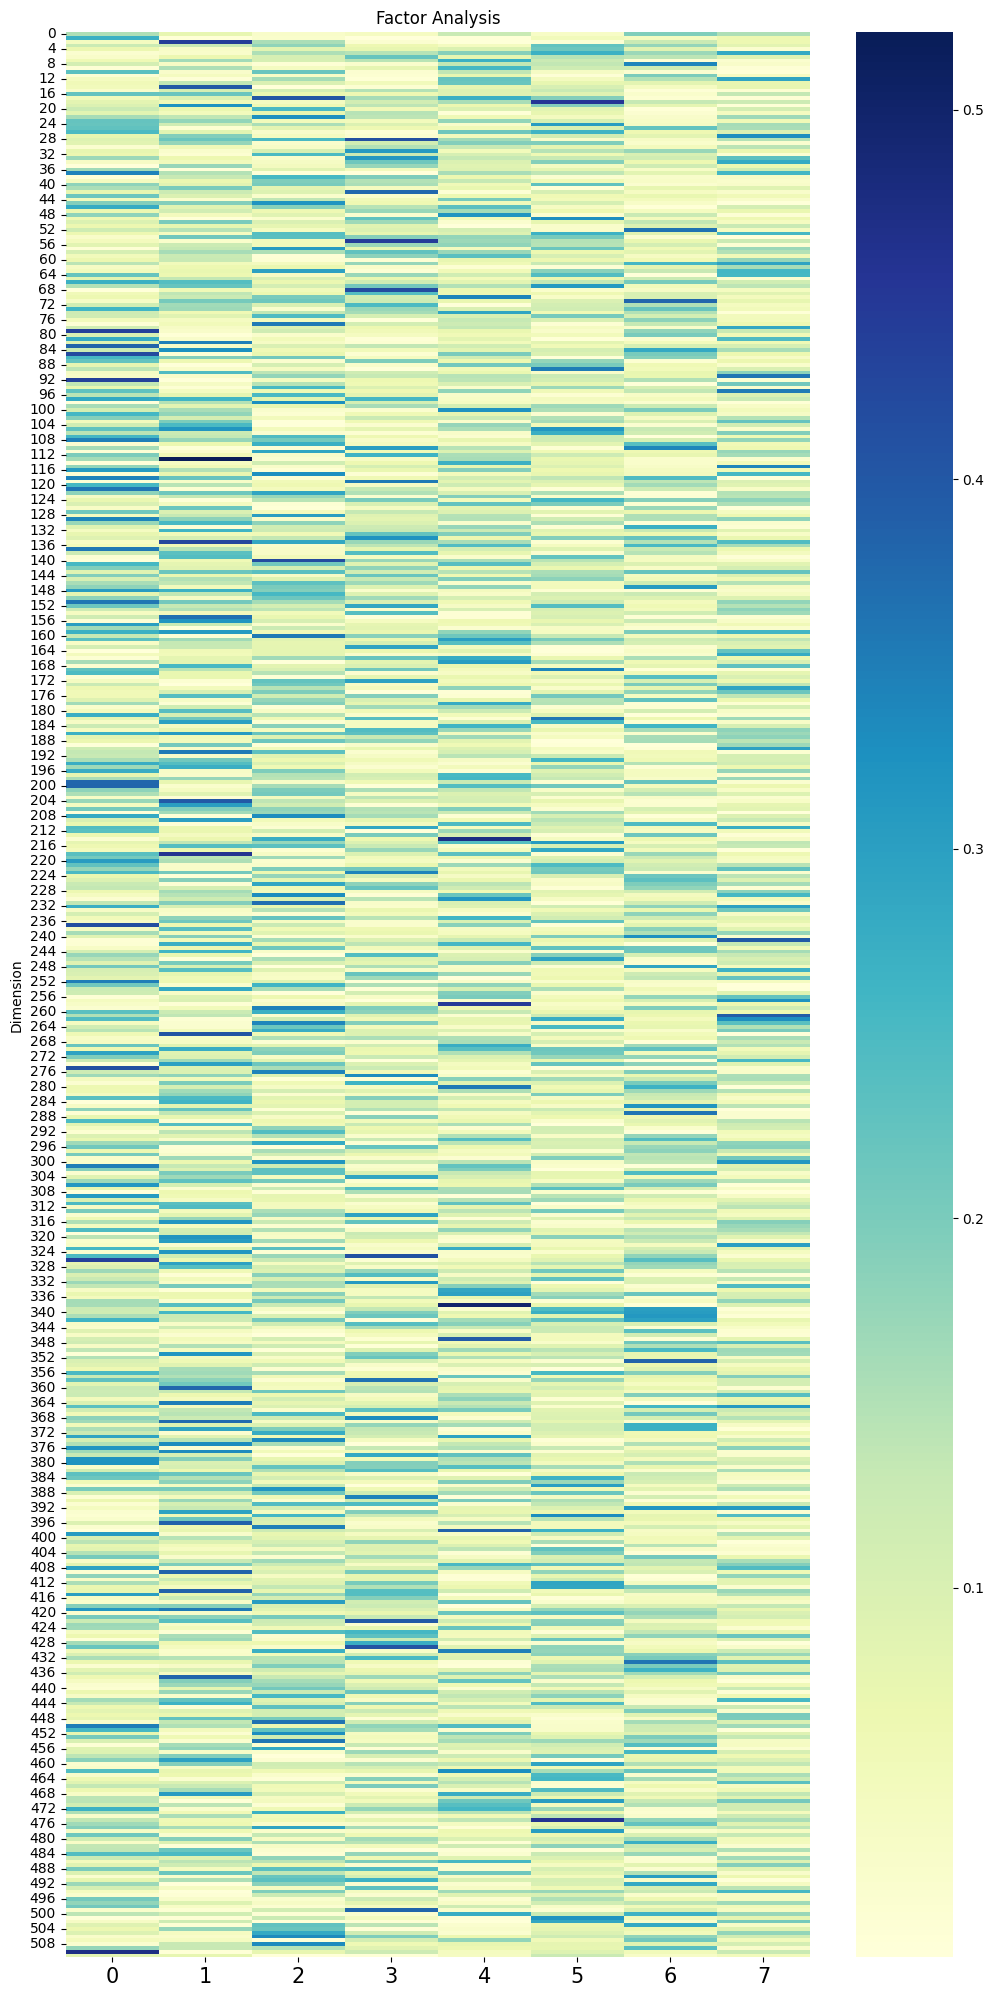

In [10]:
# 因子分析结果可视化
df_cm = pd.DataFrame(np.abs(fa.loadings_))
fig, ax = plt.subplots(figsize=(12,25))
sns.heatmap(df_cm, annot=None, cmap='YlGnBu', ax=ax)  # cbar_kws


# dict_={'orientation':'vertical',"label":"color  \
# scale","drawedges":True,"ticklocation":"top","extend":"min", \
# "filled":True,"alpha":0.8,"cmap":"cmap","ticks":tick_}
# cbar_kws = dict_

# 设置y轴字体的大小
ax.tick_params(axis='x',labelsize=15)
ax.set_title("Factor Analysis",fontsize=12)
ax.set_ylabel("Dimension")
# plt.savefig(file_path + 'snli_dimension.png')

In [11]:
plt.savefig(file_path + 'snli_dimension.png')

<Figure size 640x480 with 0 Axes>

# 模型架构

In [3]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import time
import math
import re
from gensim.models import word2vec

In [4]:
class FamAttention(nn.Module):
    """修改多头注意力，针对嵌入512维，8个head的模型"""
    def __init__(self, num_hiddens, dim_dict, dropout, bias=False, **kwargs):
        super(FamAttention, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dim_dict = dim_dict
        self.dim_0 = [dim for dim, idx in self.dim_dict.items() if idx == 0]
        self.dim_1 = [dim for dim, idx in self.dim_dict.items() if idx == 1]
        self.dim_2 = [dim for dim, idx in self.dim_dict.items() if idx == 2]
        self.dim_3 = [dim for dim, idx in self.dim_dict.items() if idx == 3]
        self.dim_4 = [dim for dim, idx in self.dim_dict.items() if idx == 4]
        self.dim_5 = [dim for dim, idx in self.dim_dict.items() if idx == 5]
        self.dim_6 = [dim for dim, idx in self.dim_dict.items() if idx == 6]
        self.dim_7 = [dim for dim, idx in self.dim_dict.items() if idx == 7]
        # self.list_concat = torch.cat((self.dim_0, self.dim_1, self.dim_2, self.dim_3, self.dim_4, self.dim_5,
        # self.dim_6, self.dim_7))
        self.len_0, self.len_1, self.len_2, self.len_3, self.len_4, self.len_5, self.len_6, self.len_7 = len(
            self.dim_0), len(self.dim_1), len(self.dim_2), len(self.dim_3), len(self.dim_4), len(self.dim_5),\
            len(self.dim_6), len(self.dim_7)

        self.Wq0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wq1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wq2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wq3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wq4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wq5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wq6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wq7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wk0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wk1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wk2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wk3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wk4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wk5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wk6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wk7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wv0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wv1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wv2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wv3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wv4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wv5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wv6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wv7 = nn.Linear(self.len_7, self.len_7, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        def assemble(output_concat, list_concat):
            reslist = []
            for i in range(512):
                reslist.append(list_concat.index(i))
            return torch.index_select(output_concat, -1, torch.tensor(reslist, device=output_concat.device))

        # queries, keys, values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # qi, ki, vi的形状：(batch_size, 查询或者“键－值”对的个数， self.len_i)
        q0, k0, v0 = torch.index_select(queries, -1, torch.tensor(self.dim_0, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_0, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_0, device=values.device))
        q1, k1, v1 = torch.index_select(queries, -1, torch.tensor(self.dim_1, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_1, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_1, device=values.device))
        q2, k2, v2 = torch.index_select(queries, -1, torch.tensor(self.dim_2, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_2, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_2, device=values.device))
        q3, k3, v3 = torch.index_select(queries, -1, torch.tensor(self.dim_3, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_3, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_3, device=values.device))
        q4, k4, v4 = torch.index_select(queries, -1, torch.tensor(self.dim_4, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_4, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_4, device=values.device))
        q5, k5, v5 = torch.index_select(queries, -1, torch.tensor(self.dim_5, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_5, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_5, device=values.device))
        q6, k6, v6 = torch.index_select(queries, -1, torch.tensor(self.dim_6, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_6, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_6, device=values.device))
        q7, k7, v7 = torch.index_select(queries, -1, torch.tensor(self.dim_7, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_7, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_7, device=values.device))

        head0 = self.attention(self.Wq0(q0), self.Wk0(k0), self.Wv0(v0), valid_lens)
        head1 = self.attention(self.Wq1(q1), self.Wk1(k1), self.Wv1(v1), valid_lens)
        head2 = self.attention(self.Wq2(q2), self.Wk2(k2), self.Wv2(v2), valid_lens)
        head3 = self.attention(self.Wq3(q3), self.Wk3(k3), self.Wv3(v3), valid_lens)
        head4 = self.attention(self.Wq4(q4), self.Wk4(k4), self.Wv4(v4), valid_lens)
        head5 = self.attention(self.Wq5(q5), self.Wk5(k5), self.Wv5(v5), valid_lens)
        head6 = self.attention(self.Wq6(q6), self.Wk6(k6), self.Wv6(v6), valid_lens)
        head7 = self.attention(self.Wq7(q7), self.Wk7(k7), self.Wv7(v7), valid_lens)

        output_concat = torch.cat((head0, head1, head2, head3, head4, head5, head6, head7), dim=-1)
        list_concat = self.dim_0 + self.dim_1 + self.dim_2 + self.dim_3 + self.dim_4 + self.dim_5 + self.dim_6 + self.dim_7
        return self.W_o(assemble(output_concat, list_concat))

In [5]:
# 编码器块
class EncoderBlock(nn.Module):
    """transformer编码器块"""

    def __init__(self, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = FamAttention(num_hiddens, dim_dict, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [6]:
class FamEncoder(nn.Module):
    """采用BERT编码器结构"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout, max_len=128,
                 **kwargs):
        super(FamEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        self.agg_layer = nn.Sequential(nn.Linear(num_hiddens, num_hiddens),
                                      nn.ReLU())
        self.output = nn.Linear(num_hiddens, 3)
        for i in range(num_layers):
            self.blks.add_module(f"{i}", EncoderBlock(
                num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, dim_dict, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        # 取句首'<cls>'标签对应的输出向量用于分类
        return self.output(self.agg_layer(X[:, 0, :]))

# 训练和测试数据集

In [7]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        premise = [self._process(sen) for sen in dataset['premise']]
        hypothesis = [self._process(sen) for sen in dataset['hypothesis']]
        # all_premise_hypothesis_tokens = [d2l.tokenize(sentences)
        #     for sentences in [premise, hypothesis]]
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize(sentences)
              for sentences in [premise, hypothesis]])]
        self.labels = torch.tensor(dataset['label'])
        if vocab is None:
            self.vocab = d2l.Vocab(d2l.tokenize(premise + hypothesis), min_freq=5,
                                   reserved_tokens=['<pad>', '<cls>', '<pad>', '<sep>'])
        else:
            self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _process(self, raw_sentences):
        raw_sentences = re.sub(r'[^0-9a-zA-Z]', ' ', raw_sentences)
        raw_sentences = re.sub('\\s{2,}', ' ', raw_sentences)
        return raw_sentences

    def _preprocess(self, all_premise_hypothesis_tokens):
        # pool = multiprocessing.Pool(4)  # 使用4个进程
        # out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        out = list(map(self._mp_worker, all_premise_hypothesis_tokens))
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [8]:
batch_size, max_len = 512, 128
train_set = SNLIBERTDataset(dataset['train'], max_len)
vocab = train_set.vocab
print(f"训练集词表大小: {len(vocab)}")
test_set = SNLIBERTDataset(dataset['test'], max_len, vocab)
validation_set = SNLIBERTDataset(dataset['validation'], max_len, vocab)

read 549367 examples
训练集词表大小: 18018
read 9824 examples
read 9842 examples


In [18]:
import os
os.cpu_count()

128

In [11]:
from collections import Counter
cnt = Counter(train_set.labels.numpy())
cnt

Counter({1: 182764, 2: 183187, 0: 183416})

In [73]:
for data in dataset['train']:
    if data['label'] == -1:
        print(data)
        break

{'premise': 'A small group of church-goers watch a choir practice.', 'hypothesis': 'A choir performs in front of packed crowd.', 'label': -1}


In [9]:
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)
validation_iter = torch.utils.data.DataLoader(validation_set, batch_size, shuffle=False)
print(f'训练集大小: {len(train_iter)}, 测试集大小: {len(test_iter)}, 验证集大小: {len(validation_iter)}')

训练集大小: 1073, 测试集大小: 20, 验证集大小: 20


# 训练准备

In [10]:
# 参数和超参数
num_hiddens, num_layers, dropout = 512, 2, 0.1
ffn_num_input, ffn_num_hiddens, num_heads, norm_shape = 512, 2048, 8, [512]
lr, num_epochs, device = 5e-5, 30, d2l.try_gpu()

In [11]:
file_path = 'autodl-tmp/'
excelfile = pd.read_excel(file_path + 'snliFA.xls', sheet_name='Sheet2', header=0, index_col=0)
dim_dict = dict()
for i in range(512):
    dim_dict[excelfile['Dimension'].values[i]] = excelfile['Factor'].values[i]

In [12]:
# 实例化模型
net = FamEncoder(
    len(vocab), num_hiddens, norm_shape, ffn_num_input,
    ffn_num_hiddens, dim_dict, num_layers, dropout)
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

14,488,731 total parameters.
14,488,731 training parameters.


In [13]:
# 初始化embedding层模型权重
def get_embedding_weights(vocab, word2vecmodel, num_hiddens):
    wordlist = word2vecmodel.wv.index_to_key
    n = len(vocab)
    data = np.random.randn(n, num_hiddens)
    for i in range(n):
        word = vocab.idx_to_token[i]
        data[i] = np.array(word2vecmodel.wv[word]) if word in wordlist else data[i]
    return torch.tensor(data, dtype=torch.float32)


def init_embedding_weights(module, weights):
    module.weight.data = weights


word2vecmodel = word2vec.Word2Vec.load(file_path + 'snli_word_vec_sg.bin')
weights = get_embedding_weights(vocab, word2vecmodel, num_hiddens)
init_embedding_weights(net.token_embedding, weights)

In [ ]:
embedding[0]

In [57]:
vocab.idx_to_token[5]

'a'

In [ ]:
net.token_embedding.weight.data[5]

In [47]:
net.segment_embedding.weight.data

tensor([[-0.5880,  0.6655, -0.1657,  ..., -1.5089, -0.6681,  1.5746],
        [-1.4953,  0.3176,  0.9931,  ..., -1.2442,  1.5790, -0.6454]])

In [14]:
# 初始化线性层权重
def xavier_init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


net.apply(xavier_init_weights)

FamEncoder(
  (token_embedding): Embedding(18018, 512)
  (segment_embedding): Embedding(2, 512)
  (blks): Sequential(
    (0): EncoderBlock(
      (attention): FamAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_o): Linear(in_features=512, out_features=512, bias=True)
        (Wq0): Linear(in_features=78, out_features=78, bias=True)
        (Wq1): Linear(in_features=77, out_features=77, bias=True)
        (Wq2): Linear(in_features=69, out_features=69, bias=True)
        (Wq3): Linear(in_features=62, out_features=62, bias=True)
        (Wq4): Linear(in_features=64, out_features=64, bias=True)
        (Wq5): Linear(in_features=52, out_features=52, bias=True)
        (Wq6): Linear(in_features=53, out_features=53, bias=True)
        (Wq7): Linear(in_features=57, out_features=57, bias=True)
        (Wk0): Linear(in_features=78, out_features=78, bias=True)
        (Wk1): Linear(in_features=77, out_features=77, bias=T

In [ ]:
for name, parameters in net.named_parameters():
    print(name, ';', parameters.size())

In [15]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for data in data_iter:
            X, y = data
            tokens, segments, valid_len = [x.to(device) for x in X]
            y = y.to(device)
            metric.add(d2l.accuracy(net(tokens, segments, valid_len), y), d2l.size(y))
    return metric[0] / metric[1]

# 正式训练(2层编码器块, 20 epochs)

In [27]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 14,488,731 total parameters.
# 20 epochs
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "token_embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.token_embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy, validation_accuracy = [], [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, segments, valid_len), y = data
        tokens, segments, valid_len = [v.to(device) for v in (tokens, segments, valid_len)]
        y = y.to(device)
        l = loss(net(tokens, segments, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(tokens, segments, valid_len), y) / batch_size
    epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
    epochtest, epochvalidation = evaluate_accuracy_gpu(net, test_iter, device), evaluate_accuracy_gpu(net, validation_iter, device)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
    validation_accuracy.append(epochvalidation)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}\n'
      f'测试集准确率:{test_accuracy[-1]:.3f}, 验证集准确率:{validation_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

100%|██████████| 1073/1073 [06:13<00:00,  2.87it/s]


epoch 1, loss 1.039, train_acc 0.467, test_acc 0.524, taking 378 seconds


100%|██████████| 1073/1073 [06:11<00:00,  2.89it/s]


epoch 2, loss 0.884, train_acc 0.596, test_acc 0.617, taking 375 seconds


100%|██████████| 1073/1073 [06:17<00:00,  2.84it/s]


epoch 3, loss 0.823, train_acc 0.633, test_acc 0.652, taking 381 seconds


100%|██████████| 1073/1073 [06:24<00:00,  2.79it/s]


epoch 4, loss 0.790, train_acc 0.654, test_acc 0.667, taking 388 seconds


100%|██████████| 1073/1073 [06:23<00:00,  2.80it/s]


epoch 5, loss 0.769, train_acc 0.666, test_acc 0.677, taking 387 seconds


100%|██████████| 1073/1073 [06:16<00:00,  2.85it/s]


epoch 6, loss 0.751, train_acc 0.676, test_acc 0.671, taking 380 seconds


100%|██████████| 1073/1073 [06:11<00:00,  2.89it/s]


epoch 7, loss 0.734, train_acc 0.686, test_acc 0.697, taking 375 seconds


100%|██████████| 1073/1073 [06:17<00:00,  2.85it/s]


epoch 8, loss 0.720, train_acc 0.694, test_acc 0.699, taking 381 seconds


100%|██████████| 1073/1073 [06:13<00:00,  2.87it/s]


epoch 9, loss 0.708, train_acc 0.701, test_acc 0.702, taking 377 seconds


100%|██████████| 1073/1073 [06:14<00:00,  2.87it/s]


epoch 10, loss 0.697, train_acc 0.707, test_acc 0.699, taking 378 seconds


100%|██████████| 1073/1073 [06:13<00:00,  2.87it/s]


epoch 11, loss 0.687, train_acc 0.711, test_acc 0.714, taking 377 seconds


100%|██████████| 1073/1073 [06:19<00:00,  2.83it/s]


epoch 12, loss 0.677, train_acc 0.717, test_acc 0.713, taking 383 seconds


100%|██████████| 1073/1073 [06:15<00:00,  2.86it/s]


epoch 13, loss 0.668, train_acc 0.722, test_acc 0.714, taking 379 seconds


100%|██████████| 1073/1073 [06:17<00:00,  2.84it/s]


epoch 14, loss 0.659, train_acc 0.726, test_acc 0.721, taking 381 seconds


100%|██████████| 1073/1073 [06:13<00:00,  2.87it/s]


epoch 15, loss 0.652, train_acc 0.731, test_acc 0.728, taking 377 seconds


100%|██████████| 1073/1073 [06:20<00:00,  2.82it/s]


epoch 16, loss 0.643, train_acc 0.735, test_acc 0.725, taking 384 seconds


100%|██████████| 1073/1073 [06:13<00:00,  2.87it/s]


epoch 17, loss 0.635, train_acc 0.739, test_acc 0.731, taking 377 seconds


100%|██████████| 1073/1073 [06:13<00:00,  2.88it/s]


epoch 18, loss 0.627, train_acc 0.743, test_acc 0.735, taking 377 seconds


100%|██████████| 1073/1073 [06:18<00:00,  2.84it/s]


epoch 19, loss 0.617, train_acc 0.749, test_acc 0.741, taking 382 seconds


100%|██████████| 1073/1073 [06:12<00:00,  2.88it/s]


epoch 20, loss 0.607, train_acc 0.753, test_acc 0.744, taking 376 seconds
Training is finished.
训练损失:0.607, 训练集准确率:0.753
测试集准确率:0.744, 验证集准确率:0.742
在设备cuda:0上训练20周期 耗时7595 秒


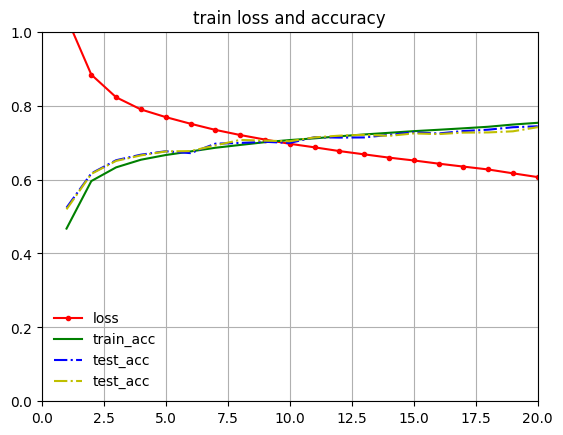

In [28]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, num_epochs, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy, validation_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.plot(epochs, validation_accuracy, 'y-.', label='valid_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

# 正式训练(2层, 30epochs)

In [16]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 14,488,731 total parameters.
# 30 epochs
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "token_embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.token_embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy, validation_accuracy = [], [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, segments, valid_len), y = data
        tokens, segments, valid_len = [v.to(device) for v in (tokens, segments, valid_len)]
        y = y.to(device)
        l = loss(net(tokens, segments, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(tokens, segments, valid_len), y) / batch_size
    epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
    epochtest, epochvalidation = evaluate_accuracy_gpu(net, test_iter, device), evaluate_accuracy_gpu(net, validation_iter, device)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
    validation_accuracy.append(epochvalidation)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}\n'
      f'测试集准确率:{test_accuracy[-1]:.3f}, 验证集准确率:{validation_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

100%|██████████| 1073/1073 [06:35<00:00,  2.71it/s]


epoch 1, loss 1.046, train_acc 0.458, test_acc 0.552, taking 400 seconds


100%|██████████| 1073/1073 [06:28<00:00,  2.76it/s]


epoch 2, loss 0.892, train_acc 0.591, test_acc 0.626, taking 392 seconds


100%|██████████| 1073/1073 [06:27<00:00,  2.77it/s]


epoch 3, loss 0.829, train_acc 0.629, test_acc 0.657, taking 391 seconds


100%|██████████| 1073/1073 [06:28<00:00,  2.76it/s]


epoch 4, loss 0.795, train_acc 0.650, test_acc 0.669, taking 392 seconds


100%|██████████| 1073/1073 [06:31<00:00,  2.74it/s]


epoch 5, loss 0.773, train_acc 0.664, test_acc 0.680, taking 395 seconds


100%|██████████| 1073/1073 [06:29<00:00,  2.75it/s]


epoch 6, loss 0.753, train_acc 0.675, test_acc 0.687, taking 394 seconds


100%|██████████| 1073/1073 [06:28<00:00,  2.76it/s]


epoch 7, loss 0.737, train_acc 0.684, test_acc 0.691, taking 392 seconds


100%|██████████| 1073/1073 [06:31<00:00,  2.74it/s]


epoch 8, loss 0.723, train_acc 0.693, test_acc 0.699, taking 395 seconds


100%|██████████| 1073/1073 [06:30<00:00,  2.75it/s]


epoch 9, loss 0.710, train_acc 0.700, test_acc 0.703, taking 394 seconds


100%|██████████| 1073/1073 [06:28<00:00,  2.76it/s]


epoch 10, loss 0.697, train_acc 0.706, test_acc 0.710, taking 392 seconds


100%|██████████| 1073/1073 [06:29<00:00,  2.76it/s]


epoch 11, loss 0.687, train_acc 0.711, test_acc 0.712, taking 393 seconds


100%|██████████| 1073/1073 [06:25<00:00,  2.78it/s]


epoch 12, loss 0.677, train_acc 0.718, test_acc 0.719, taking 389 seconds


100%|██████████| 1073/1073 [06:30<00:00,  2.75it/s]


epoch 13, loss 0.667, train_acc 0.722, test_acc 0.717, taking 394 seconds


100%|██████████| 1073/1073 [06:29<00:00,  2.76it/s]


epoch 14, loss 0.657, train_acc 0.727, test_acc 0.723, taking 393 seconds


100%|██████████| 1073/1073 [06:31<00:00,  2.74it/s]


epoch 15, loss 0.649, train_acc 0.731, test_acc 0.722, taking 395 seconds


100%|██████████| 1073/1073 [06:28<00:00,  2.76it/s]


epoch 16, loss 0.641, train_acc 0.736, test_acc 0.732, taking 393 seconds


100%|██████████| 1073/1073 [06:27<00:00,  2.77it/s]


epoch 17, loss 0.632, train_acc 0.740, test_acc 0.732, taking 391 seconds


100%|██████████| 1073/1073 [06:28<00:00,  2.76it/s]


epoch 18, loss 0.624, train_acc 0.745, test_acc 0.736, taking 393 seconds


100%|██████████| 1073/1073 [06:29<00:00,  2.76it/s]


epoch 19, loss 0.615, train_acc 0.749, test_acc 0.730, taking 393 seconds


100%|██████████| 1073/1073 [06:29<00:00,  2.76it/s]


epoch 20, loss 0.606, train_acc 0.753, test_acc 0.740, taking 393 seconds


100%|██████████| 1073/1073 [06:24<00:00,  2.79it/s]


epoch 21, loss 0.598, train_acc 0.757, test_acc 0.730, taking 388 seconds


100%|██████████| 1073/1073 [06:24<00:00,  2.79it/s]


epoch 22, loss 0.589, train_acc 0.762, test_acc 0.737, taking 388 seconds


100%|██████████| 1073/1073 [06:24<00:00,  2.79it/s]


epoch 23, loss 0.582, train_acc 0.766, test_acc 0.749, taking 388 seconds


100%|██████████| 1073/1073 [06:25<00:00,  2.79it/s]


epoch 24, loss 0.574, train_acc 0.769, test_acc 0.746, taking 389 seconds


100%|██████████| 1073/1073 [06:25<00:00,  2.78it/s]


epoch 25, loss 0.566, train_acc 0.773, test_acc 0.748, taking 389 seconds


100%|██████████| 1073/1073 [06:24<00:00,  2.79it/s]


epoch 26, loss 0.559, train_acc 0.777, test_acc 0.755, taking 388 seconds


100%|██████████| 1073/1073 [06:24<00:00,  2.79it/s]


epoch 27, loss 0.552, train_acc 0.781, test_acc 0.753, taking 388 seconds


100%|██████████| 1073/1073 [06:23<00:00,  2.80it/s]


epoch 28, loss 0.544, train_acc 0.784, test_acc 0.760, taking 387 seconds


100%|██████████| 1073/1073 [06:27<00:00,  2.77it/s]


epoch 29, loss 0.537, train_acc 0.788, test_acc 0.756, taking 391 seconds


100%|██████████| 1073/1073 [06:28<00:00,  2.76it/s]


epoch 30, loss 0.530, train_acc 0.790, test_acc 0.763, taking 393 seconds
Training is finished.
训练损失:0.530, 训练集准确率:0.790
测试集准确率:0.763, 验证集准确率:0.756
在设备cuda:0上训练30周期 耗时11755 秒


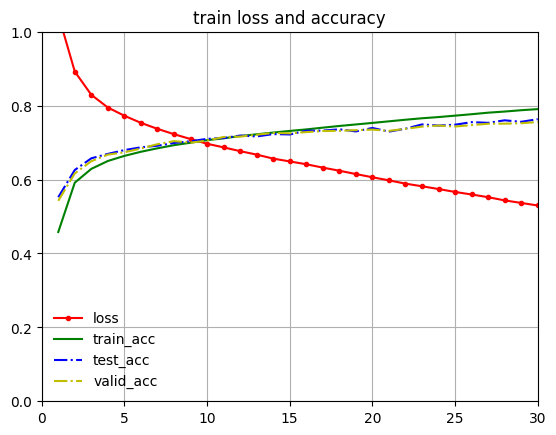

In [17]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, num_epochs, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy, validation_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.plot(epochs, validation_accuracy, 'y-.', label='valid_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

# 正式训练(3层编码器块)

In [20]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 16,955,111 total parameters.
num_epochs = 30
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "token_embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.token_embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy, validation_accuracy = [], [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, segments, valid_len), y = data
        tokens, segments, valid_len = [v.to(device) for v in (tokens, segments, valid_len)]
        y = y.to(device)
        l = loss(net(tokens, segments, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(tokens, segments, valid_len), y) / batch_size
    epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
    epochtest, epochvalidation = evaluate_accuracy_gpu(net, test_iter, device), evaluate_accuracy_gpu(net, validation_iter, device)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, valid_acc {epochvalidation:.3f}, '
          f'taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
    validation_accuracy.append(epochvalidation)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}\n'
      f'测试集准确率:{test_accuracy[-1]:.3f}, 验证集准确率:{validation_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

100%|██████████| 1073/1073 [09:13<00:00,  1.94it/s]


epoch 1, loss 1.050, train_acc 0.448, test_acc 0.540, valid_acc 0.531, taking 560 seconds


100%|██████████| 1073/1073 [09:14<00:00,  1.94it/s]


epoch 2, loss 0.906, train_acc 0.582, test_acc 0.624, valid_acc 0.614, taking 560 seconds


100%|██████████| 1073/1073 [09:17<00:00,  1.92it/s]


epoch 3, loss 0.831, train_acc 0.630, test_acc 0.648, valid_acc 0.645, taking 563 seconds


100%|██████████| 1073/1073 [09:14<00:00,  1.94it/s]


epoch 4, loss 0.793, train_acc 0.653, test_acc 0.669, valid_acc 0.664, taking 559 seconds


100%|██████████| 1073/1073 [09:15<00:00,  1.93it/s]


epoch 5, loss 0.767, train_acc 0.669, test_acc 0.680, valid_acc 0.678, taking 561 seconds


100%|██████████| 1073/1073 [09:10<00:00,  1.95it/s]


epoch 6, loss 0.742, train_acc 0.682, test_acc 0.698, valid_acc 0.695, taking 556 seconds


100%|██████████| 1073/1073 [09:09<00:00,  1.95it/s]


epoch 7, loss 0.722, train_acc 0.694, test_acc 0.703, valid_acc 0.699, taking 554 seconds


100%|██████████| 1073/1073 [09:10<00:00,  1.95it/s]


epoch 8, loss 0.701, train_acc 0.706, test_acc 0.716, valid_acc 0.712, taking 556 seconds


100%|██████████| 1073/1073 [09:10<00:00,  1.95it/s]


epoch 9, loss 0.679, train_acc 0.718, test_acc 0.723, valid_acc 0.723, taking 556 seconds


100%|██████████| 1073/1073 [09:10<00:00,  1.95it/s]


epoch 10, loss 0.658, train_acc 0.730, test_acc 0.736, valid_acc 0.736, taking 556 seconds


100%|██████████| 1073/1073 [09:19<00:00,  1.92it/s]


epoch 11, loss 0.628, train_acc 0.745, test_acc 0.759, valid_acc 0.755, taking 564 seconds


100%|██████████| 1073/1073 [09:16<00:00,  1.93it/s]


epoch 12, loss 0.599, train_acc 0.759, test_acc 0.764, valid_acc 0.760, taking 562 seconds


100%|██████████| 1073/1073 [09:20<00:00,  1.92it/s]


epoch 13, loss 0.577, train_acc 0.770, test_acc 0.775, valid_acc 0.772, taking 565 seconds


100%|██████████| 1073/1073 [09:15<00:00,  1.93it/s]


epoch 14, loss 0.560, train_acc 0.778, test_acc 0.781, valid_acc 0.779, taking 561 seconds


100%|██████████| 1073/1073 [09:18<00:00,  1.92it/s]


epoch 15, loss 0.544, train_acc 0.786, test_acc 0.789, valid_acc 0.790, taking 564 seconds


100%|██████████| 1073/1073 [09:19<00:00,  1.92it/s]


epoch 16, loss 0.530, train_acc 0.791, test_acc 0.791, valid_acc 0.791, taking 564 seconds


100%|██████████| 1073/1073 [09:26<00:00,  1.89it/s]


epoch 17, loss 0.518, train_acc 0.797, test_acc 0.798, valid_acc 0.792, taking 572 seconds


100%|██████████| 1073/1073 [09:22<00:00,  1.91it/s]


epoch 18, loss 0.507, train_acc 0.802, test_acc 0.793, valid_acc 0.793, taking 568 seconds


100%|██████████| 1073/1073 [09:28<00:00,  1.89it/s]


epoch 19, loss 0.496, train_acc 0.807, test_acc 0.798, valid_acc 0.798, taking 575 seconds


100%|██████████| 1073/1073 [09:34<00:00,  1.87it/s]


epoch 20, loss 0.487, train_acc 0.811, test_acc 0.802, valid_acc 0.801, taking 580 seconds


100%|██████████| 1073/1073 [09:32<00:00,  1.88it/s]


epoch 21, loss 0.477, train_acc 0.816, test_acc 0.804, valid_acc 0.802, taking 578 seconds


100%|██████████| 1073/1073 [09:32<00:00,  1.87it/s]


epoch 22, loss 0.468, train_acc 0.820, test_acc 0.811, valid_acc 0.808, taking 579 seconds


100%|██████████| 1073/1073 [09:30<00:00,  1.88it/s]


epoch 23, loss 0.460, train_acc 0.824, test_acc 0.809, valid_acc 0.811, taking 576 seconds


100%|██████████| 1073/1073 [09:24<00:00,  1.90it/s]


epoch 24, loss 0.453, train_acc 0.827, test_acc 0.814, valid_acc 0.808, taking 570 seconds


100%|██████████| 1073/1073 [09:25<00:00,  1.90it/s]


epoch 25, loss 0.445, train_acc 0.829, test_acc 0.813, valid_acc 0.809, taking 571 seconds


100%|██████████| 1073/1073 [09:25<00:00,  1.90it/s]


epoch 26, loss 0.439, train_acc 0.833, test_acc 0.811, valid_acc 0.815, taking 571 seconds


100%|██████████| 1073/1073 [09:35<00:00,  1.87it/s]


epoch 27, loss 0.431, train_acc 0.836, test_acc 0.812, valid_acc 0.811, taking 581 seconds


100%|██████████| 1073/1073 [09:32<00:00,  1.87it/s]


epoch 28, loss 0.425, train_acc 0.839, test_acc 0.814, valid_acc 0.817, taking 579 seconds


100%|██████████| 1073/1073 [09:41<00:00,  1.85it/s]


epoch 29, loss 0.419, train_acc 0.842, test_acc 0.817, valid_acc 0.819, taking 587 seconds


100%|██████████| 1073/1073 [09:41<00:00,  1.85it/s]


epoch 30, loss 0.413, train_acc 0.845, test_acc 0.814, valid_acc 0.812, taking 587 seconds
Training is finished.
训练损失:0.413, 训练集准确率:0.845
测试集准确率:0.814, 验证集准确率:0.812
在设备cuda:0上训练30周期 耗时17032 秒


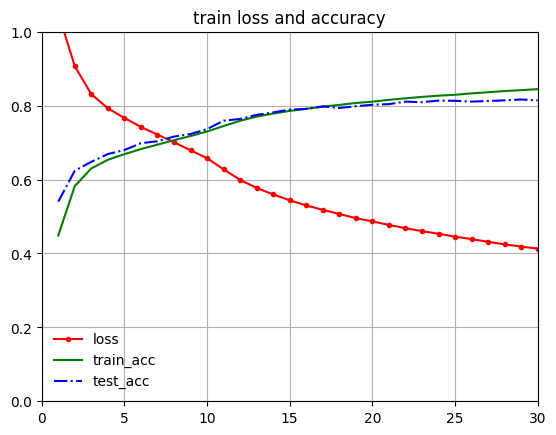

In [22]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, num_epochs, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy, validation_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
# plt.plot(epochs, validation_accuracy, 'y-.', label='valid_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

# 对比训练(2层编码器块)

In [13]:
# 常规编码器
class BaseEncoder(nn.Module):
    """采用BERT编码器结构"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=128, key_size=512, query_size=512, value_size=512,
                 **kwargs):
        super(BaseEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        self.agg_layer = nn.Sequential(nn.Linear(num_hiddens, num_hiddens),
                                      nn.ReLU())
        self.output = nn.Linear(num_hiddens, 3)
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        # 取句首'<cls>'标签对应的输出向量用于分类
        return self.output(self.agg_layer(X[:, 0, :]))

In [14]:
num_heads = 8
basenet = BaseEncoder(
    len(vocab), num_hiddens, norm_shape, ffn_num_input,
    ffn_num_hiddens, num_heads, num_layers, dropout)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in basenet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in basenet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

15,860,739 total parameters.
15,860,739 training parameters.


In [15]:
init_embedding_weights(basenet.token_embedding, weights)
basenet.apply(xavier_init_weights)

BaseEncoder(
  (token_embedding): Embedding(18018, 512)
  (segment_embedding): Embedding(2, 512)
  (blks): Sequential(
    (0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=512, out_features=2048, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (addnorm2): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
   

In [16]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 15,860,739 total parameters.
# num_epochs = 30
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in basenet.named_parameters()
    if name != "token_embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': basenet.token_embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
basenet.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy, validation_accuracy = [], [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    basenet.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, segments, valid_len), y = data
        tokens, segments, valid_len = [v.to(device) for v in (tokens, segments, valid_len)]
        y = y.to(device)
        l = loss(basenet(tokens, segments, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(basenet(tokens, segments, valid_len), y) / batch_size
    epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
    epochtest, epochvalidation = evaluate_accuracy_gpu(basenet, test_iter, device), evaluate_accuracy_gpu(basenet, validation_iter, device)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, valid_acc {epochvalidation:.3f}, '
          f'taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
    validation_accuracy.append(epochvalidation)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}\n'
      f'测试集准确率:{test_accuracy[-1]:.3f}, 验证集准确率:{validation_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

100%|██████████| 1073/1073 [04:13<00:00,  4.23it/s]


epoch 1, loss 1.053, train_acc 0.447, test_acc 0.529, valid_acc 0.518, taking 256 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.19it/s]


epoch 2, loss 0.905, train_acc 0.582, test_acc 0.613, valid_acc 0.605, taking 258 seconds


100%|██████████| 1073/1073 [04:17<00:00,  4.17it/s]


epoch 3, loss 0.831, train_acc 0.628, test_acc 0.642, valid_acc 0.640, taking 260 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 4, loss 0.800, train_acc 0.647, test_acc 0.665, valid_acc 0.655, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 5, loss 0.780, train_acc 0.661, test_acc 0.666, valid_acc 0.666, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 6, loss 0.764, train_acc 0.670, test_acc 0.674, valid_acc 0.667, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 7, loss 0.751, train_acc 0.679, test_acc 0.673, valid_acc 0.668, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.21it/s]


epoch 8, loss 0.740, train_acc 0.685, test_acc 0.694, valid_acc 0.685, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.21it/s]


epoch 9, loss 0.732, train_acc 0.689, test_acc 0.695, valid_acc 0.691, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 10, loss 0.725, train_acc 0.693, test_acc 0.694, valid_acc 0.692, taking 258 seconds


100%|██████████| 1073/1073 [04:14<00:00,  4.22it/s]


epoch 11, loss 0.716, train_acc 0.697, test_acc 0.694, valid_acc 0.688, taking 257 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 12, loss 0.707, train_acc 0.702, test_acc 0.691, valid_acc 0.694, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 13, loss 0.699, train_acc 0.706, test_acc 0.707, valid_acc 0.703, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 14, loss 0.693, train_acc 0.710, test_acc 0.713, valid_acc 0.707, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 15, loss 0.687, train_acc 0.713, test_acc 0.711, valid_acc 0.712, taking 258 seconds


100%|██████████| 1073/1073 [04:16<00:00,  4.19it/s]


epoch 16, loss 0.681, train_acc 0.716, test_acc 0.715, valid_acc 0.712, taking 259 seconds


100%|██████████| 1073/1073 [04:16<00:00,  4.19it/s]


epoch 17, loss 0.674, train_acc 0.720, test_acc 0.716, valid_acc 0.711, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 18, loss 0.672, train_acc 0.721, test_acc 0.702, valid_acc 0.703, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.20it/s]


epoch 19, loss 0.665, train_acc 0.725, test_acc 0.722, valid_acc 0.719, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.19it/s]


epoch 20, loss 0.660, train_acc 0.727, test_acc 0.717, valid_acc 0.713, taking 258 seconds


100%|██████████| 1073/1073 [04:15<00:00,  4.21it/s]


epoch 21, loss 0.655, train_acc 0.730, test_acc 0.730, valid_acc 0.725, taking 258 seconds


100%|██████████| 1073/1073 [04:14<00:00,  4.21it/s]


epoch 22, loss 0.652, train_acc 0.731, test_acc 0.728, valid_acc 0.732, taking 257 seconds


100%|██████████| 1073/1073 [04:14<00:00,  4.21it/s]


epoch 23, loss 0.645, train_acc 0.733, test_acc 0.731, valid_acc 0.730, taking 257 seconds


100%|██████████| 1073/1073 [04:14<00:00,  4.21it/s]


epoch 24, loss 0.643, train_acc 0.735, test_acc 0.730, valid_acc 0.733, taking 257 seconds


100%|██████████| 1073/1073 [04:14<00:00,  4.22it/s]


epoch 25, loss 0.640, train_acc 0.736, test_acc 0.731, valid_acc 0.736, taking 257 seconds


100%|██████████| 1073/1073 [04:14<00:00,  4.22it/s]


epoch 26, loss 0.639, train_acc 0.737, test_acc 0.731, valid_acc 0.732, taking 257 seconds


100%|██████████| 1073/1073 [04:14<00:00,  4.22it/s]


epoch 27, loss 0.634, train_acc 0.739, test_acc 0.725, valid_acc 0.726, taking 257 seconds


100%|██████████| 1073/1073 [04:14<00:00,  4.21it/s]


epoch 28, loss 0.631, train_acc 0.741, test_acc 0.733, valid_acc 0.737, taking 257 seconds


100%|██████████| 1073/1073 [04:13<00:00,  4.23it/s]


epoch 29, loss 0.626, train_acc 0.743, test_acc 0.735, valid_acc 0.741, taking 256 seconds


100%|██████████| 1073/1073 [04:13<00:00,  4.23it/s]


epoch 30, loss 0.622, train_acc 0.745, test_acc 0.735, valid_acc 0.731, taking 256 seconds
Training is finished.
训练损失:0.622, 训练集准确率:0.745
测试集准确率:0.735, 验证集准确率:0.731
在设备cuda:0上训练30周期 耗时7730 秒


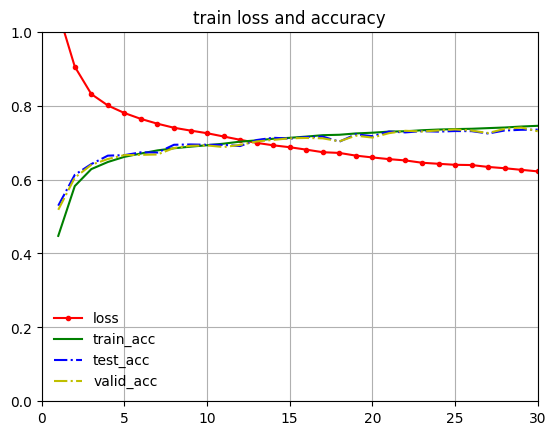

In [17]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, num_epochs, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy, validation_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.plot(epochs, validation_accuracy, 'y-.', label='valid_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

# 对比训练(3层编码器块)

In [15]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 19,013,123 total parameters.
# num_epochs = 30
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in basenet.named_parameters()
    if name != "token_embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': basenet.token_embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
basenet.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy, validation_accuracy = [], [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    basenet.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, segments, valid_len), y = data
        tokens, segments, valid_len = [v.to(device) for v in (tokens, segments, valid_len)]
        y = y.to(device)
        l = loss(basenet(tokens, segments, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(basenet(tokens, segments, valid_len), y) / batch_size
    epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
    epochtest, epochvalidation = evaluate_accuracy_gpu(basenet, test_iter, device), evaluate_accuracy_gpu(basenet, validation_iter, device)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, valid_acc {epochvalidation:.3f}, '
          f'taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
    validation_accuracy.append(epochvalidation)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}\n'
      f'测试集准确率:{test_accuracy[-1]:.3f}, 验证集准确率:{validation_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

100%|██████████| 1073/1073 [06:11<00:00,  2.89it/s]


epoch 1, loss 1.079, train_acc 0.413, test_acc 0.501, valid_acc 0.489, taking 375 seconds


100%|██████████| 1073/1073 [06:15<00:00,  2.86it/s]


epoch 2, loss 0.947, train_acc 0.554, test_acc 0.603, valid_acc 0.606, taking 379 seconds


100%|██████████| 1073/1073 [06:14<00:00,  2.87it/s]


epoch 3, loss 0.873, train_acc 0.610, test_acc 0.597, valid_acc 0.599, taking 378 seconds


100%|██████████| 1073/1073 [06:14<00:00,  2.87it/s]


epoch 4, loss 0.855, train_acc 0.619, test_acc 0.625, valid_acc 0.626, taking 378 seconds


100%|██████████| 1073/1073 [06:15<00:00,  2.86it/s]


epoch 5, loss 0.844, train_acc 0.625, test_acc 0.625, valid_acc 0.622, taking 379 seconds


100%|██████████| 1073/1073 [06:16<00:00,  2.85it/s]


epoch 6, loss 0.835, train_acc 0.631, test_acc 0.626, valid_acc 0.624, taking 381 seconds


100%|██████████| 1073/1073 [06:17<00:00,  2.84it/s]


epoch 7, loss 0.828, train_acc 0.634, test_acc 0.631, valid_acc 0.637, taking 381 seconds


100%|██████████| 1073/1073 [06:20<00:00,  2.82it/s]


epoch 8, loss 0.825, train_acc 0.635, test_acc 0.631, valid_acc 0.633, taking 384 seconds


100%|██████████| 1073/1073 [06:16<00:00,  2.85it/s]


epoch 9, loss 0.819, train_acc 0.638, test_acc 0.642, valid_acc 0.641, taking 381 seconds


100%|██████████| 1073/1073 [06:14<00:00,  2.87it/s]


epoch 10, loss 0.820, train_acc 0.637, test_acc 0.639, valid_acc 0.640, taking 378 seconds


100%|██████████| 1073/1073 [06:16<00:00,  2.85it/s]


epoch 11, loss 0.812, train_acc 0.642, test_acc 0.643, valid_acc 0.637, taking 380 seconds


100%|██████████| 1073/1073 [06:18<00:00,  2.84it/s]


epoch 12, loss 0.810, train_acc 0.642, test_acc 0.640, valid_acc 0.638, taking 382 seconds


100%|██████████| 1073/1073 [06:16<00:00,  2.85it/s]


epoch 13, loss 0.806, train_acc 0.644, test_acc 0.625, valid_acc 0.630, taking 381 seconds


100%|██████████| 1073/1073 [06:17<00:00,  2.84it/s]


epoch 14, loss 0.804, train_acc 0.645, test_acc 0.647, valid_acc 0.637, taking 382 seconds


100%|██████████| 1073/1073 [06:14<00:00,  2.87it/s]


epoch 15, loss 0.806, train_acc 0.643, test_acc 0.641, valid_acc 0.645, taking 378 seconds


100%|██████████| 1073/1073 [06:15<00:00,  2.85it/s]


epoch 16, loss 0.802, train_acc 0.645, test_acc 0.646, valid_acc 0.642, taking 379 seconds


100%|██████████| 1073/1073 [06:15<00:00,  2.85it/s]


epoch 17, loss 0.800, train_acc 0.646, test_acc 0.645, valid_acc 0.645, taking 380 seconds


100%|██████████| 1073/1073 [06:16<00:00,  2.85it/s]


epoch 18, loss 0.794, train_acc 0.651, test_acc 0.645, valid_acc 0.645, taking 380 seconds


100%|██████████| 1073/1073 [06:15<00:00,  2.85it/s]


epoch 19, loss 0.793, train_acc 0.650, test_acc 0.649, valid_acc 0.651, taking 379 seconds


100%|██████████| 1073/1073 [06:12<00:00,  2.88it/s]


epoch 20, loss 0.793, train_acc 0.650, test_acc 0.650, valid_acc 0.651, taking 376 seconds


100%|██████████| 1073/1073 [06:12<00:00,  2.88it/s]


epoch 21, loss 0.791, train_acc 0.651, test_acc 0.643, valid_acc 0.642, taking 376 seconds


100%|██████████| 1073/1073 [06:14<00:00,  2.87it/s]


epoch 22, loss 0.791, train_acc 0.651, test_acc 0.650, valid_acc 0.650, taking 378 seconds


100%|██████████| 1073/1073 [06:13<00:00,  2.88it/s]


epoch 23, loss 0.788, train_acc 0.652, test_acc 0.649, valid_acc 0.648, taking 377 seconds


100%|██████████| 1073/1073 [06:12<00:00,  2.88it/s]


epoch 24, loss 0.785, train_acc 0.653, test_acc 0.647, valid_acc 0.645, taking 376 seconds


100%|██████████| 1073/1073 [06:13<00:00,  2.87it/s]


epoch 25, loss 0.781, train_acc 0.656, test_acc 0.654, valid_acc 0.652, taking 377 seconds


100%|██████████| 1073/1073 [06:14<00:00,  2.86it/s]


epoch 26, loss 0.778, train_acc 0.657, test_acc 0.637, valid_acc 0.636, taking 378 seconds


100%|██████████| 1073/1073 [06:14<00:00,  2.87it/s]


epoch 27, loss 0.788, train_acc 0.651, test_acc 0.640, valid_acc 0.641, taking 378 seconds


100%|██████████| 1073/1073 [06:13<00:00,  2.87it/s]


epoch 28, loss 0.805, train_acc 0.641, test_acc 0.632, valid_acc 0.632, taking 377 seconds


100%|██████████| 1073/1073 [06:15<00:00,  2.86it/s]


epoch 29, loss 0.793, train_acc 0.648, test_acc 0.626, valid_acc 0.635, taking 379 seconds


100%|██████████| 1073/1073 [06:14<00:00,  2.87it/s]


epoch 30, loss 0.794, train_acc 0.647, test_acc 0.646, valid_acc 0.642, taking 378 seconds
Training is finished.
训练损失:0.794, 训练集准确率:0.647
测试集准确率:0.646, 验证集准确率:0.642
在设备cuda:0上训练30周期 耗时11363 秒


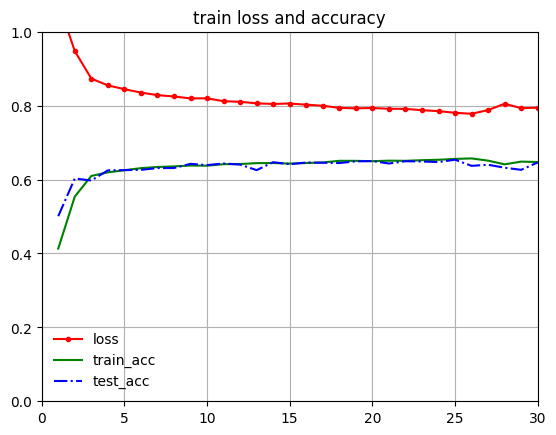

In [16]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, num_epochs, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy, validation_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
# plt.plot(epochs, validation_accuracy, 'y-.', label='valid_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

In [22]:
!nvidia-smi

Sat Oct  8 15:25:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    On   | 00000000:CE:00.0 Off |                  Off |
| 30%   27C    P8    15W / 230W |  24247MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
!kill -9 pid

/bin/bash: line 0: kill: pid: arguments must be process or job IDs
